### Problem Statement
The dataset "Course Reviews and Ratings " contains reviews of different courses offered by a university. <br> In this project I will train a classifier which helps to predict the ‘course_rating’ column, which indicates whether the course was liked or disliked by the reviewer.
 
###### Aim of the Project is : <br>
- Finding interesting insights and patterns
- Cleaning and preprocessing the data
- Feature engineering to help train your classifier
- Training an efficient and scalable model (Try to use different ML algorithms and think about what works best in this case)
- Splitting the dataset into 80%/20% for train/test sets, in order to evaluate the performance of your classifier (Think about the best way to split for an accurate representation of your performance)
- Deciding upon the optimal performance metrics to for this case


In [ ]:
## All Necessary imports
import pandas as pd
import numpy as np

# Natural Language Toolkit(NLTK) Library to preprocess text data
from nltk.corpus import wordnet
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

# Vader To get sentiments of reviews
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#  For words cloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt


#gensim to generate word embeddings
from gensim.models.doc2vec import TaggedDocument
from tqdm import tqdm 
import gensim

# sklearn to perform ml modelling
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

# for balancing the classes
from imblearn.over_sampling import SMOTE


import warnings
warnings.filterwarnings('ignore'

##### Data Exploration

In [6]:
# Load dataset using pandas 
dataset = pd.read_csv("ds_challenge.csv")
dataset.head()

,course_code,course_title,num_ratings,useful,easy,liked,num_reviews,reviews,course_rating
0,CS 115,Introduction to Computer Science 1,2111,21%,10%,23%,86,go to office hours and practice,liked course
1,CS 115,Introduction to Computer Science 1,2111,21%,10%,23%,86,One of my least favourite courses. Although th...,disliked course
2,CS 115,Introduction to Computer Science 1,2111,21%,10%,23%,86,It starts with a very low pace but after midte...,disliked course
3,CS 115,Introduction to Computer Science 1,2111,21%,10%,23%,86,Took this in 2018 with no programming experien...,liked course
4,CS 115,Introduction to Computer Science 1,2111,21%,10%,23%,86,I loved everything about cs 115. Great instruc...,liked course


In [68]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14838 entries, 0 to 14837
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   course_code    14838 non-null  object
 1   course_title   14838 non-null  object
 2   num_ratings    14838 non-null  int64 
 3   useful         14836 non-null  object
 4   easy           14835 non-null  object
 5   liked          14835 non-null  object
 6   num_reviews    14838 non-null  int64 
 7   reviews        14834 non-null  object
 8   course_rating  14616 non-null  object
dtypes: int64(2), object(7)
memory usage: 1.0+ MB


In [69]:
len(dataset["course_code"].unique())

1974

### Data Cleaning and Preprocessing

In [70]:
# Check for any empty values
dataset[dataset.isnull().any(axis=1)].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 229 entries, 50 to 14837
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   course_code    229 non-null    object
 1   course_title   229 non-null    object
 2   num_ratings    229 non-null    int64 
 3   useful         227 non-null    object
 4   easy           226 non-null    object
 5   liked          226 non-null    object
 6   num_reviews    229 non-null    int64 
 7   reviews        225 non-null    object
 8   course_rating  7 non-null      object
dtypes: int64(2), object(7)
memory usage: 17.9+ KB


Comment : As there are 229 records in the whole dataset containing any null values. And 222 of them are in our target variable. So it is better to drop the rerords containing any null value.

In [71]:
# Dropping rows containing any empty value/s
dataset = dataset[~dataset.isnull().any(axis=1)]
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14609 entries, 0 to 14834
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   course_code    14609 non-null  object
 1   course_title   14609 non-null  object
 2   num_ratings    14609 non-null  int64 
 3   useful         14609 non-null  object
 4   easy           14609 non-null  object
 5   liked          14609 non-null  object
 6   num_reviews    14609 non-null  int64 
 7   reviews        14609 non-null  object
 8   course_rating  14609 non-null  object
dtypes: int64(2), object(7)
memory usage: 1.1+ MB


In [72]:
print("Number of Unique Courses in dataset : ", len(dataset["course_code"].unique()))

Number of Unique Courses in dataset :  1961


In [73]:
# dataset.groupby(["course_code","course_rating"])["course_rating"].count()

Let's have a look at our target variable.

In [74]:
dataset["course_rating"].unique()

array(['liked course', 'disliked course', 'Disliked course',
       'dislikedcourse', 'Liked cousre', 'likedcourse'], dtype=object)

Comment: It needs cleaning, as there are multiple strings representing the same value.

In [75]:
# Replace all target values with appropriate labels
dataset.replace({"course_rating" : {'liked course' : 'Liked',
                                    'Liked cousre' : 'Liked',
                                    'likedcourse' : 'Liked',
                                    'disliked course' : 'Disliked',
                                    'Disliked course' : 'Disliked',
                                    'dislikedcourse' : 'Disliked',
                                   }}, inplace = True)

Let's have a look at the target variable counts.

In [76]:
print("Count of each target variable in our dataset")
print(dataset["course_rating"].value_counts())

Count of each target variable in our dataset
Liked       9782
Disliked    4827
Name: course_rating, dtype: int64


In [77]:
print("Percentage of count of each target variable in our dataset")
dataset["course_rating"].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

Percentage of count of each target variable in our dataset


Liked       67.0%
Disliked    33.0%
Name: course_rating, dtype: object

<b> Comment : Imbalanced dataset, as there are only 33% "Disliked" reviews and 66% "Liked" reviews </b>

In [78]:
# what faculties do we have in our dataset?
dataset["course_code"].str.split().str.get(0).unique()

array(['CS', 'MATH', 'ECON', 'PSYCH', 'CHE', 'PD', 'STAT', 'CHEM', 'ENGL',
       'BIOL', 'ECE', 'SPCOM', 'AFM', 'PHYS', 'SOC', 'CLAS', 'MSCI', 'SE',
       'COOP', 'WKRPT', 'GEOG', 'ENVS', 'SCI', 'HRM', 'PHIL', 'CO',
       'GENE', 'MUSIC', 'EARTH', 'FR', 'LS', 'INTST', 'ARBUS', 'MTE',
       'JAPAN', 'PLAN', 'SPAN', 'ACTSC', 'AMATH', 'HLTH', 'MTHEL', 'BUS',
       'ME', 'SYDE', 'FINE', 'ARTS', 'AHS', 'KIN', 'REC', 'BET', 'GER',
       'STV', 'KOREA', 'GBDA', 'PSCI', 'SDS', 'PACS', 'ERS', 'EMLS',
       'SOCWK', 'CIVE', 'SMF', 'CHINA', 'PMATH', 'NE', 'INDEV', 'INTEG',
       'SCBUS', 'ANTH', 'ENBUS', 'ITAL', 'RS', 'HIST', 'AVIA', 'COMM',
       'EASIA', 'BME', 'ESL', 'WS', 'VCULT', 'MNS', 'ENVE', 'DRAMA',
       'LAT', 'SI', 'DUTCH', 'RUSS', 'PORT', 'BASE', 'GEOE', 'GERON',
       'ITALST', 'HUMSC', 'PHARM', 'MGMT', 'CROAT', 'DAC', 'GRK', 'JS',
       'REES', 'SEQ', 'INDG', 'GSJ', 'CFM', 'APPLS', 'ACC', 'ARCH', 'ISS',
       'ARABIC', 'THPERF', 'ASL', 'ACINTY', 'COGSCI', 'SWREN', 'SVE

In [79]:
# The following 3 attrubutes contained a character "%", 
# To pass these variables, we'll have to clean and convert them into numeric.
dataset["useful"] = dataset["useful"].str[:-1].astype(int)
dataset["easy"] = dataset["easy"].str[:-1].astype(int)
dataset["liked"] = dataset["liked"].str[:-1].astype(int)

In [80]:
dataset.head()

,course_code,course_title,num_ratings,useful,easy,liked,num_reviews,reviews,course_rating
0,CS 115,Introduction to Computer Science 1,2111,21,10,23,86,go to office hours and practice,Liked
1,CS 115,Introduction to Computer Science 1,2111,21,10,23,86,One of my least favourite courses. Although th...,Disliked
2,CS 115,Introduction to Computer Science 1,2111,21,10,23,86,It starts with a very low pace but after midte...,Disliked
3,CS 115,Introduction to Computer Science 1,2111,21,10,23,86,Took this in 2018 with no programming experien...,Liked
4,CS 115,Introduction to Computer Science 1,2111,21,10,23,86,I loved everything about cs 115. Great instruc...,Liked


Let's have a look at "Liked" and "Disliked" reviews.

In [81]:
dataset[dataset['course_rating'] == "Liked"]["reviews"].head(10)

0                       go to office hours and practice
3     Took this in 2018 with no programming experien...
4     I loved everything about cs 115. Great instruc...
5     I recommend finding a course with a language t...
6     I really enjoyed this course online, being co-...
8     The only way to do bad in this course is by no...
9     Can be difficult at times, but a very rewardin...
11    Not a bird course, although if you have backgr...
12    I took this course online due to the COVID-19 ...
13    I found the online for this course to be fanta...
Name: reviews, dtype: object

In [82]:
dataset[dataset['course_rating'] == "Disliked"]["reviews"].head(10)

1     One of my least favourite courses. Although th...
2     It starts with a very low pace but after midte...
7     math student who took this course since I had ...
10    This course is taught in an archaic language t...
16    It's the worst course ever, online especially....
20    The education quality is significantly impaire...
21                           so difficult for beginners
22    Not an "EASY" course at all. Anyone commentati...
26    It's hard to motivate yourself to do the assig...
34                                        i hate racket
Name: reviews, dtype: object

#### Preprocess reviews

In [83]:
## return the wordnet object value corresponding to the POS tag
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    

## Clean the text
def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

In [84]:
# clean text data i.e., reviews
dataset["reviews"] = dataset["reviews"].apply(lambda x: clean_text(x))
dataset = dataset.reset_index()

In [85]:
dataset["reviews"]

0                                  go office hour practice
1        one least favourite course although thing nice...
2        start low pace midterm get really fast cannot ...
3        take program experience ever start pretty slow...
4        love everything great instructor fair assignme...
                               ...                        
14604    really wonderful course dr fraser easton great...
14605    course end relatively interesting unnecessaril...
14606    personally find computational biomechanics use...
14607    take online georgia whalen asl level two defin...
14608    either design help design majority course guar...
Name: reviews, Length: 14609, dtype: object

In [23]:
# wordcloud function
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
#         background_color = "white",

        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()

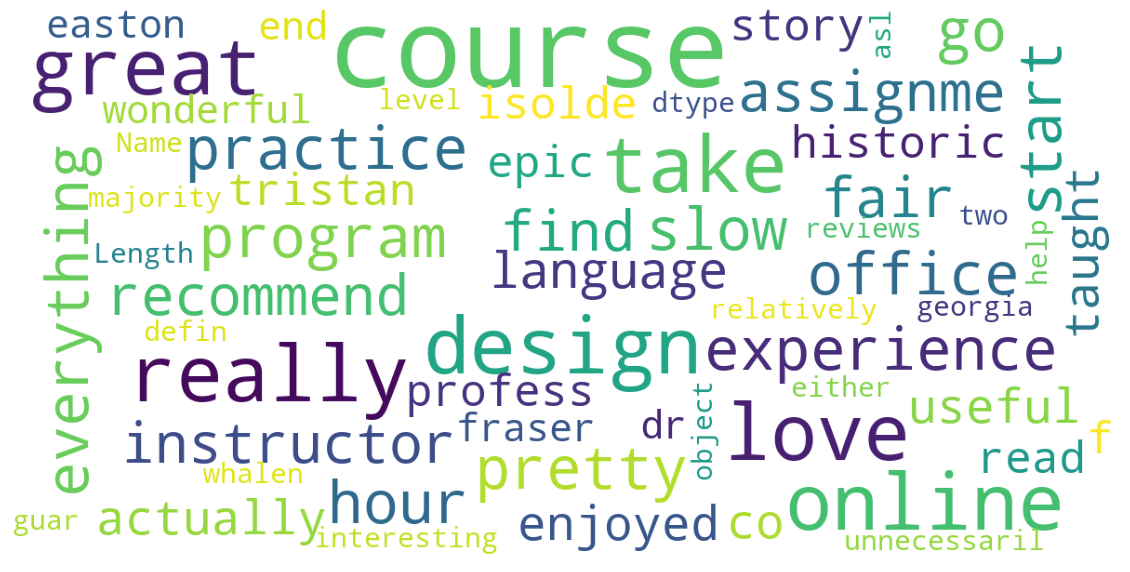

In [31]:
# print wordcloud for "Liked" class
show_wordcloud(dataset[dataset["course_rating"] == "Liked"]["reviews"])

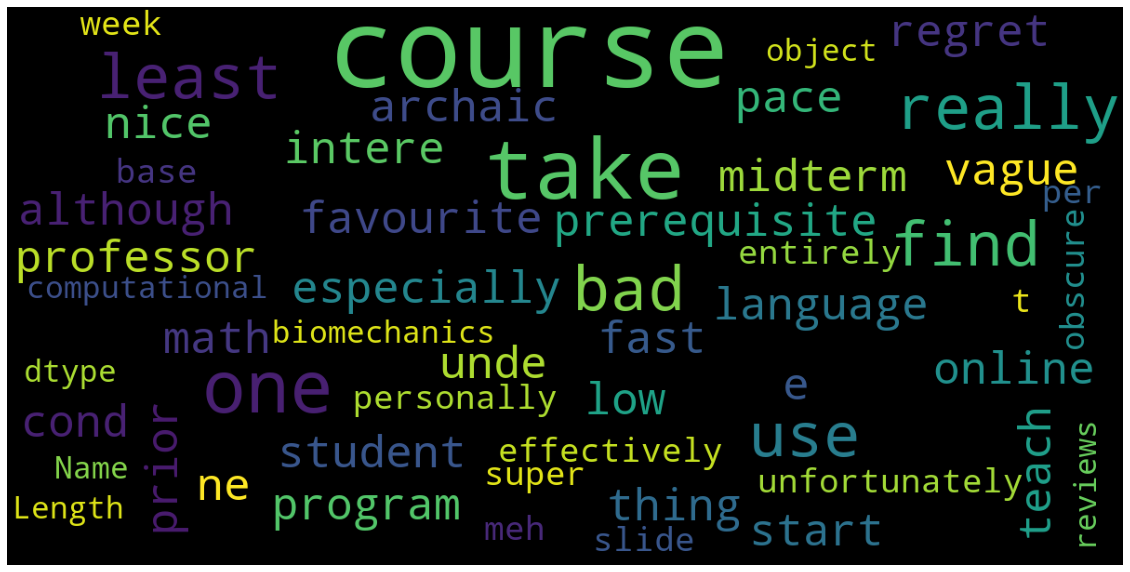

In [33]:
# print wordcloud for "Disliked" class
show_wordcloud(dataset[dataset["course_rating"] == "Disliked"]["reviews"])

### Feature Engineering

In [86]:
## Generate sentiment of each review
sid = SentimentIntensityAnalyzer()
dataset["sentiments"] = dataset["reviews"].apply(lambda x: sid.polarity_scores(x))
dataset = pd.concat([dataset.drop(['sentiments'], axis=1), dataset['sentiments'].apply(pd.Series)], axis=1)

# add number of characters column
dataset["num_chars"] = dataset["reviews"].apply(lambda x: len(x))

# add number of words column
dataset["num_words"] = dataset["reviews"].apply(lambda x: len(x.split(" ")))
dataset

,index,course_code,course_title,num_ratings,useful,easy,liked,num_reviews,reviews,course_rating,neg,neu,pos,compound,num_chars,num_words
0,0,CS 115,Introduction to Computer Science 1,2111,21,10,23,86,go office hour practice,Liked,0.000,1.000,0.000,0.0000,23,4
1,1,CS 115,Introduction to Computer Science 1,2111,21,10,23,86,one least favourite course although thing nice...,Disliked,0.100,0.584,0.316,0.7430,147,21
2,2,CS 115,Introduction to Computer Science 1,2111,21,10,23,86,start low pace midterm get really fast cannot ...,Disliked,0.179,0.511,0.310,0.8567,263,40
3,3,CS 115,Introduction to Computer Science 1,2111,21,10,23,86,take program experience ever start pretty slow...,Liked,0.209,0.632,0.159,-0.1654,175,26
4,4,CS 115,Introduction to Computer Science 1,2111,21,10,23,86,love everything great instructor fair assignme...,Liked,0.072,0.350,0.578,0.9723,197,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14604,14830,GSJ 410,Eighteenth-Century Women Writers,1,75,75,100,1,really wonderful course dr fraser easton great...,Liked,0.000,0.445,0.555,0.9347,116,19
14605,14831,SOC 436,Alcohol and Well-Being,1,50,25,100,1,course end relatively interesting unnecessaril...,Liked,0.084,0.762,0.154,0.5719,351,45
14606,14832,BME 588,Special Topics in Biomechanics,1,25,25,0,1,personally find computational biomechanics use...,Disliked,0.000,0.815,0.185,0.7579,302,36
14607,14833,ASL 102R,American Sign Language 2,1,100,75,100,1,take online georgia whalen asl level two defin...,Liked,0.000,0.831,0.169,0.8399,415,59


In [87]:
# highest positive sentiment reviews
dataset.sort_values("pos", ascending = False)[["reviews", "pos"]].head(10)

,reviews,pos
9831,important,1.0
8329,super interesting,1.0
4414,super easy,1.0
4412,easy,1.0
6413,easy,1.0
4342,important,1.0
2913,easy fun,1.0
6440,amaze,1.0
13649,lol,1.0
9432,worth,1.0


In [88]:
# highest positive sentiment reviews
dataset.sort_values("neg", ascending = False)[["reviews", "neg"]].head(10)

,reviews,neg
11338,meh,1.0
1460,meh,1.0
6667,doom,1.0
1370,bullshit,1.0
6023,hard hard,1.0
1898,awful,1.0
3761,kill,1.0
9635,bore bore boring,1.0
3115,stressful,1.0
1907,hard,1.0


### Generate Word Embeddings
##### We'll try the following word embedding techniques:
- Word2Vec
- Doc2Vec

In [26]:
# Function to tag each review
def add_label(rvw):
    output = []
    for i, s in zip(rvw.index, rvw):
        output.append(TaggedDocument(s, ["review_" + str(i)]))
    return output

In [27]:
tokenized_review = dataset["reviews"].apply(lambda x: x.split()) # tokenizing 
tagged_reviews = add_label(tokenized_review) # tag all the reviews

##### Word2Vec model

In [34]:
model_w2v = gensim.models.Word2Vec(
            tokenized_review,
            vector_size=200, # desired no. of features/independent variables
            window=5, # context window size
            min_count=2, # Ignores all words with total frequency lower than 2.                                  
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 32, # no.of cores
            seed = 34
)
model_w2v.train(tokenized_review, total_examples= len(dataset["reviews"]), epochs=2)

(466590, 586662)

In [35]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += model_w2v.wv[word].reshape((1, size))
            count += 1.
        except KeyError:  # handling the case where the token is not in vocabulary
            continue
    if count != 0:
        vec /= count
    return vec

In [36]:
wordvec_arrays = np.zeros((len(tokenized_review), 200)) 
for i in range(len(tokenized_review)):
    wordvec_arrays[i,:] = word_vector(tokenized_review[i], 200)
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

(14609, 200)

In [37]:
wordvec_df.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.034926,0.165019,-0.043861,0.103000,-0.364881,0.065566,-0.026996,-0.034799,0.122740,-0.189689,...,-0.147885,-0.200114,0.212010,-0.241017,0.144822,0.161401,0.024503,-0.212426,-0.248378,-0.223518
1,-0.051289,-0.174768,-0.139416,0.107807,-0.177258,-0.020646,-0.180135,-0.050245,0.045186,-0.002751,...,-0.081045,-0.204995,0.004910,-0.098562,0.036189,0.128696,0.015694,-0.192515,-0.094200,0.005354
2,-0.044136,-0.129330,-0.065256,0.072860,-0.229102,-0.021292,-0.156201,-0.067463,0.076891,-0.052656,...,-0.025813,-0.174874,0.043558,-0.161794,0.055951,0.136168,0.006422,-0.144640,-0.134370,-0.044986
3,0.012625,-0.079515,-0.084822,0.145261,-0.206273,-0.052813,-0.104039,-0.092731,0.031752,-0.114295,...,-0.022355,-0.248563,0.084174,-0.210984,0.077965,0.193321,-0.036179,-0.224113,-0.092609,-0.068379
4,0.025860,-0.108238,-0.056251,0.080760,-0.246718,-0.002834,-0.144229,-0.041546,0.102309,-0.030733,...,-0.051745,-0.221190,0.113871,-0.211911,0.071943,0.139204,-0.071672,-0.217596,-0.112111,0.001121


##### Doc2Vec Model

In [38]:
## Generate word embeddings using Doc2Vec technique.
model_d2v = gensim.models.Doc2Vec(dm=1, # dm = 1 for ‘distributed memory’ model
                                  dm_mean=1, # dm_mean = 1 for using mean of the context word vectors
                                  vector_size=200, # no. of desired features
                                  window=5, # width of the context window                                  
                                  negative=7, # if > 0 then negative sampling will be used
                                  min_count=5, # Ignores all words with total frequency lower than 5.                                  
                                  workers=32, # no. of cores                                  
                                  alpha=0.1, # learning rate                                  
                                  seed = 23, # for reproducibility
                                 ) 

model_d2v.build_vocab([i for i in tqdm(tagged_reviews)])

model_d2v.train(tagged_reviews, total_examples= len(dataset["reviews"]), epochs=15)

100%|███████████████████████████████████████████████████████████████████████| 14609/14609 [00:00<00:00, 7305029.46it/s]


In [39]:
docvec_arrays = np.zeros((len(tokenized_review), 200)) 
for i in range(len(dataset)):
    docvec_arrays[i,:] = model_d2v.docvecs[i].reshape((1,200))    

docvec_df = pd.DataFrame(docvec_arrays) 
docvec_df.shape

(14609, 200)

In [40]:
docvec_df.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.281502,0.115696,-0.239741,-0.027851,-0.107540,-0.082146,0.191585,0.017313,0.239912,-0.181484,...,-0.039244,-0.233561,-0.177425,-0.029872,-0.076570,-0.209600,0.018303,0.197371,-0.057384,-0.302415
1,-0.412695,0.160398,0.078374,-0.343475,0.356454,-0.599555,-0.161082,0.256457,0.424942,0.058059,...,0.698675,-0.008463,-0.283577,-0.200542,0.176119,0.033899,-0.267416,0.496702,-0.320872,-0.147859
2,-0.070047,0.150766,-0.063994,-0.068360,0.137135,-0.333971,0.308374,-0.308908,0.127418,-0.079303,...,-0.307585,-0.219086,-0.206084,0.327909,-0.541641,-0.084792,-0.242336,0.774174,0.057974,-0.275048
3,-0.058948,0.646506,-0.124040,-0.125830,-0.671952,-0.445656,-0.096360,-0.082474,0.609920,-0.003847,...,0.065798,-0.237905,-0.395131,0.239162,-0.731900,-0.032368,-0.387484,-0.021749,0.119334,-0.618785
4,0.316625,0.030883,-0.498774,0.181263,-0.954885,0.103918,0.123840,0.131825,0.437548,0.079836,...,-0.389956,-0.450505,-0.283380,-0.222449,0.149426,0.212481,0.373283,-0.250527,0.165458,-0.460527


In [89]:
dataset = dataset.drop(['course_code','course_title','reviews'], axis=1).reset_index().drop(['index','level_0'], axis=1)
dataset

,num_ratings,useful,easy,liked,num_reviews,course_rating,neg,neu,pos,compound,num_chars,num_words
0,2111,21,10,23,86,Liked,0.000,1.000,0.000,0.0000,23,4
1,2111,21,10,23,86,Disliked,0.100,0.584,0.316,0.7430,147,21
2,2111,21,10,23,86,Disliked,0.179,0.511,0.310,0.8567,263,40
3,2111,21,10,23,86,Liked,0.209,0.632,0.159,-0.1654,175,26
4,2111,21,10,23,86,Liked,0.072,0.350,0.578,0.9723,197,27
...,...,...,...,...,...,...,...,...,...,...,...,...
14604,1,75,75,100,1,Liked,0.000,0.445,0.555,0.9347,116,19
14605,1,50,25,100,1,Liked,0.084,0.762,0.154,0.5719,351,45
14606,1,25,25,0,1,Disliked,0.000,0.815,0.185,0.7579,302,36
14607,1,100,75,100,1,Liked,0.000,0.831,0.169,0.8399,415,59


In [90]:
wordvec_final_df = pd.concat([dataset, wordvec_df], axis=1)
docvec_final_df = pd.concat([dataset, docvec_df], axis=1)

In [92]:
wordvec_final_df.head()

,num_ratings,useful,easy,liked,num_reviews,course_rating,neg,neu,pos,compound,...,190,191,192,193,194,195,196,197,198,199
0,2111,21,10,23,86,Liked,0.000,1.000,0.000,0.0000,...,-0.147885,-0.200114,0.212010,-0.241017,0.144822,0.161401,0.024503,-0.212426,-0.248378,-0.223518
1,2111,21,10,23,86,Disliked,0.100,0.584,0.316,0.7430,...,-0.081045,-0.204995,0.004910,-0.098562,0.036189,0.128696,0.015694,-0.192515,-0.094200,0.005354
2,2111,21,10,23,86,Disliked,0.179,0.511,0.310,0.8567,...,-0.025813,-0.174874,0.043558,-0.161794,0.055951,0.136168,0.006422,-0.144640,-0.134370,-0.044986
3,2111,21,10,23,86,Liked,0.209,0.632,0.159,-0.1654,...,-0.022355,-0.248563,0.084174,-0.210984,0.077965,0.193321,-0.036179,-0.224113,-0.092609,-0.068379
4,2111,21,10,23,86,Liked,0.072,0.350,0.578,0.9723,...,-0.051745,-0.221190,0.113871,-0.211911,0.071943,0.139204,-0.071672,-0.217596,-0.112111,0.001121


In [93]:
docvec_final_df.head()

,num_ratings,useful,easy,liked,num_reviews,course_rating,neg,neu,pos,compound,...,190,191,192,193,194,195,196,197,198,199
0,2111,21,10,23,86,Liked,0.000,1.000,0.000,0.0000,...,-0.039244,-0.233561,-0.177425,-0.029872,-0.076570,-0.209600,0.018303,0.197371,-0.057384,-0.302415
1,2111,21,10,23,86,Disliked,0.100,0.584,0.316,0.7430,...,0.698675,-0.008463,-0.283577,-0.200542,0.176119,0.033899,-0.267416,0.496702,-0.320872,-0.147859
2,2111,21,10,23,86,Disliked,0.179,0.511,0.310,0.8567,...,-0.307585,-0.219086,-0.206084,0.327909,-0.541641,-0.084792,-0.242336,0.774174,0.057974,-0.275048
3,2111,21,10,23,86,Liked,0.209,0.632,0.159,-0.1654,...,0.065798,-0.237905,-0.395131,0.239162,-0.731900,-0.032368,-0.387484,-0.021749,0.119334,-0.618785
4,2111,21,10,23,86,Liked,0.072,0.350,0.578,0.9723,...,-0.389956,-0.450505,-0.283380,-0.222449,0.149426,0.212481,0.373283,-0.250527,0.165458,-0.460527


### Modelling 
##### We'll try following Machine Learning Algorithms
- Logistic Regression
- Support Vector Machines
- RandomForest
- XGBoost

In [154]:
target_names = ['Disliked','Liked']

def visualizeResults(y_test, y_pred, subtitle):

    conf_matrix = confusion_matrix(y_test, y_pred)

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
    
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title("Confusion Matrix (" + subtitle + " )", fontsize=14)
    plt.show()

In [155]:
# Replace all target values with appropriate labels
wordvec_final_df.replace({"course_rating" : {'Liked': 1,
                                     'Disliked': 0,
                                   }}, inplace = True)
docvec_final_df.replace({"course_rating" : {'Liked': 1,
                                     'Disliked': 0,
                                   }}, inplace = True)

In [156]:
#Normalize the specific columns
min_max_scaler = preprocessing.MinMaxScaler()
wordvec_final_df_scaled = wordvec_final_df.copy()
wordvec_final_df_scaled[["num_ratings","useful","easy","liked","num_reviews", "num_chars","num_words"]] = min_max_scaler.fit_transform(wordvec_final_df_scaled[["num_ratings","useful","easy","liked","num_reviews", "num_chars","num_words"]])

docvec_final_df_scaled = docvec_final_df.copy()
docvec_final_df_scaled[["num_ratings","useful","easy","liked","num_reviews", "num_chars","num_words"]] = min_max_scaler.fit_transform(docvec_final_df_scaled[["num_ratings","useful","easy","liked","num_reviews", "num_chars","num_words"]])

In [157]:
# Stratified Test-Train Split on doc2vec dataset.
X_train_dw, X_test_dw, y_train_dw, y_test_dw = train_test_split(docvec_final_df_scaled.drop(['course_rating'], axis=1), docvec_final_df_scaled['course_rating'],
                                                    stratify=docvec_final_df_scaled['course_rating'], 
                                                    test_size=0.20)
print("doc2vec scaled stratified test-train split")
print("Shape of Train Features Dataset : ", X_train.shape)
print("Shape of Train Target Dataset : ", y_train.shape)
print("Shape of Test Features Dataset : ", X_test.shape)
print("Shape of Test Target Dataset : ", y_test.shape)

doc2vec scaled stratified test-train split
Shape of Train Features Dataset :  (11687, 211)
Shape of Train Target Dataset :  (11687,)
Shape of Test Features Dataset :  (2922, 211)
Shape of Test Target Dataset :  (2922,)


In [158]:
# Stratified Test-Train Split on word2vec dataset.
X_train_wv, X_test_wv, y_train_wv, y_test_wv = train_test_split(wordvec_final_df_scaled.drop(['course_rating'], axis=1), wordvec_final_df_scaled['course_rating'],
                                                    stratify=wordvec_final_df_scaled['course_rating'], 
                                                    test_size=0.20)
print("word2vec scaled stratified test-train split")
print("Shape of Train Features Dataset : ", X_train.shape)
print("Shape of Train Target Dataset : ", y_train.shape)
print("Shape of Test Features Dataset : ", X_test.shape)
print("Shape of Test Target Dataset : ", y_test.shape)

word2vec scaled stratified test-train split
Shape of Train Features Dataset :  (11687, 211)
Shape of Train Target Dataset :  (11687,)
Shape of Test Features Dataset :  (2922, 211)
Shape of Test Target Dataset :  (2922,)


##### 1. Logistic Regression
###### using Doc2Vec

In [159]:
lreg = LogisticRegression(solver='lbfgs') 

# training the model 
lreg.fit(X_train_dw, y_train_dw) 

LogisticRegression()

In [160]:
prediction = lreg.predict_proba(X_test_dw) # predicting on the validation set 
y_pred = prediction[:,1] >= 0.5 # if prediction is greater than or equal to 0.3 than 1 else 0 
y_pred = y_pred.astype(np.int) 
print(classification_report(y_test_dw, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    Disliked       0.69      0.55      0.61       965
       Liked       0.80      0.88      0.84      1957

    accuracy                           0.77      2922
   macro avg       0.75      0.72      0.73      2922
weighted avg       0.76      0.77      0.76      2922



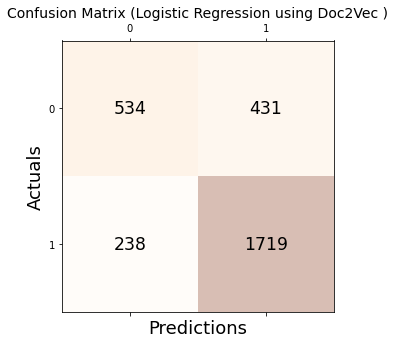

In [161]:
visualizeResults(y_test_dw,  y_pred, "Logistic Regression using Doc2Vec")

Comment : The model is performing bad on disliked class ,
We can see that 403 samples out of 965 from "Dislike" class are labelled as "Liked".
he model is biased towards the "Liked" class due to the imbalanced classes.

Let's create synthetic data by oversapmling the under-represnted class using SMOTE library

In [210]:
os = SMOTE(random_state=1810, k_neighbors = 10)
columns = X_train_dw.columns
os_data_X_dw,os_data_y_dw=os.fit_resample(X_train_dw, y_train_dw)
os_data_X_dw = pd.DataFrame(data=os_data_X_dw,columns=columns )
os_data_y_dw= pd.DataFrame(data=os_data_y_dw,columns=['course_rating'])
# # we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X_dw))
print("Number of Disliked",len(os_data_y_dw[os_data_y_dw['course_rating']== 0]))
print("Number of Liked",len(os_data_y_dw[os_data_y_dw['course_rating']== 1]))
print("Proportion of Disliked ",len(os_data_y_dw[os_data_y_dw['course_rating']== 0])/len(os_data_X_dw))
print("Proportion of Liked",len(os_data_y_dw[os_data_y_dw['course_rating']== 1])/len(os_data_X_dw))

length of oversampled data is  15650
Number of Disliked 7825
Number of Liked 7825
Proportion of Disliked  0.5
Proportion of Liked 0.5


In [186]:
lreg = LogisticRegression(solver='lbfgs') 

# training the model 
lreg.fit(os_data_X, os_data_y) 

LogisticRegression()

In [187]:
prediction = lreg.predict_proba(X_test_dw) # predicting on the validation set 
y_pred = prediction[:,1] >= 0.5 # if prediction is greater than or equal to 0.5 than 1 else 0 
y_pred = y_pred.astype(np.int) 
print(classification_report(y_test_dw, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    Disliked       0.60      0.71      0.65       965
       Liked       0.84      0.76      0.80      1957

    accuracy                           0.75      2922
   macro avg       0.72      0.74      0.72      2922
weighted avg       0.76      0.75      0.75      2922



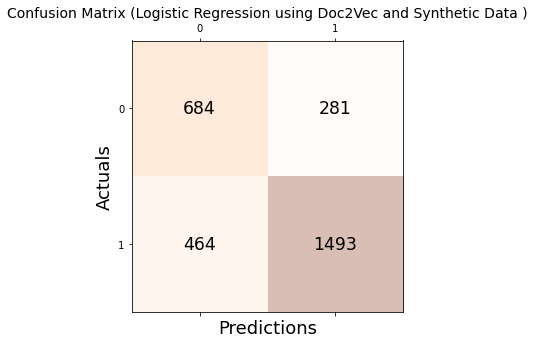

In [188]:
visualizeResults(y_test_dw,  y_pred, "Logistic Regression using Doc2Vec and Synthetic Data")

##### Logistic Regression on Word2Vec

In [189]:
lreg = LogisticRegression(solver='lbfgs') 

# training the model 
lreg.fit(X_train_wv, y_train_wv) 

LogisticRegression()

In [190]:
prediction = lreg.predict_proba(X_test_wv) # predicting on the validation set 
y_pred = prediction[:,1] >= 0.5 # if prediction is greater than or equal to 0.3 than 1 else 0 
y_pred = y_pred.astype(np.int) 
print(classification_report(y_test_wv, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    Disliked       0.71      0.57      0.63       965
       Liked       0.81      0.88      0.84      1957

    accuracy                           0.78      2922
   macro avg       0.76      0.73      0.74      2922
weighted avg       0.78      0.78      0.77      2922



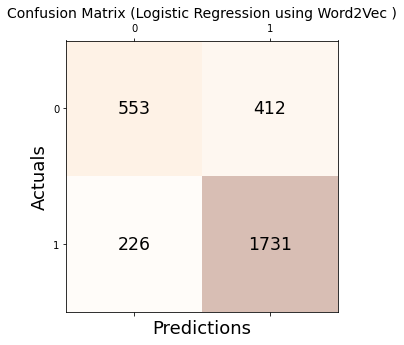

In [191]:
visualizeResults(y_test_wv,  y_pred, "Logistic Regression using Word2Vec")

Generate Synthetic Data

In [212]:
os = SMOTE(random_state=1810, k_neighbors = 10)
columns = X_train_wv.columns
os_data_X_wv,os_data_y_wv=os.fit_resample(X_train_wv, y_train_wv)
os_data_X_wv = pd.DataFrame(data=os_data_X_wv,columns=columns )
os_data_y_wv= pd.DataFrame(data=os_data_y_wv,columns=['course_rating'])
# # we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X_wv))
print("Number of Disliked",len(os_data_y_wv[os_data_y_wv['course_rating']== 0]))
print("Number of Liked",len(os_data_y_wv[os_data_y_wv['course_rating']== 1]))
print("Proportion of Disliked ",len(os_data_y_wv[os_data_y_wv['course_rating']== 0])/len(os_data_X_wv))
print("Proportion of Liked",len(os_data_y_wv[os_data_y_wv['course_rating']== 1])/len(os_data_X_wv))

length of oversampled data is  15650
Number of Disliked 7825
Number of Liked 7825
Proportion of Disliked  0.5
Proportion of Liked 0.5


In [195]:
lreg = LogisticRegression(solver='lbfgs') 

# training the model 
lreg.fit(os_data_X, os_data_y) 


LogisticRegression()

In [196]:
prediction = lreg.predict_proba(X_test_wv) # predicting on the test set 
y_pred = prediction[:,1] >= 0.5 # if prediction is greater than or equal to 0.5 than 1 else 0 
y_pred = y_pred.astype(np.int) 
print(classification_report(y_test_wv, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    Disliked       0.62      0.75      0.68       965
       Liked       0.86      0.78      0.82      1957

    accuracy                           0.77      2922
   macro avg       0.74      0.76      0.75      2922
weighted avg       0.78      0.77      0.77      2922



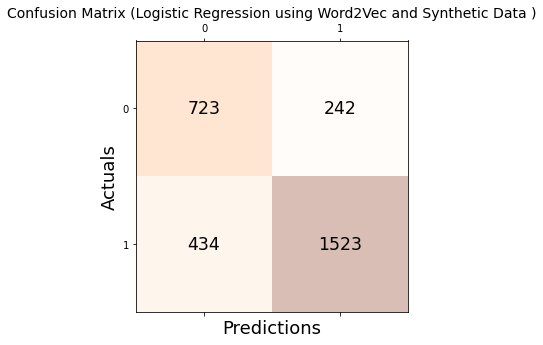

In [197]:
visualizeResults(y_test_wv,  y_pred, "Logistic Regression using Word2Vec and Synthetic Data")

#### Support Vector Machines

In [95]:
# svc = svm.SVC(kernel='linear', C=1, probability=True).fit(X_train, y_train) 

C:\Users\NoumanNusrallah\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [96]:
prediction = svc.predict_proba(X_test)  # predicting on the validation set 
y_pred = prediction[:,1] >= 0.5 # if prediction is greater than or equal to 0.3 than 1 else 0 
y_pred = y_pred.astype(np.int) 
f1_score(y_test, y_pred) # calculating f1 score for the validation set

C:\Users\NoumanNusrallah\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
<ipython-input-96-96b614657645>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pred = y_pred.astype(np.int)


0.845670053217223

In [100]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    Disliked       0.72      0.56      0.63       965
       Liked       0.80      0.89      0.85      1957

    accuracy                           0.78      2922
   macro avg       0.76      0.72      0.74      2922
weighted avg       0.78      0.78      0.77      2922



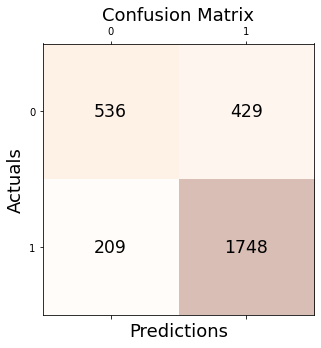

In [97]:
visualizeResults(y_test,  y_pred)

#### 3. RandomForest
##### 3.1 Using Doc2Vec

In [207]:
rf = RandomForestClassifier(n_estimators=800, random_state=11).fit(X_train_dw, y_train_dw)

In [208]:
y_pred = rf.predict(X_test_dw) 
print(classification_report(y_test_dw, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    Disliked       0.75      0.44      0.55       965
       Liked       0.77      0.93      0.84      1957

    accuracy                           0.77      2922
   macro avg       0.76      0.68      0.70      2922
weighted avg       0.76      0.77      0.75      2922



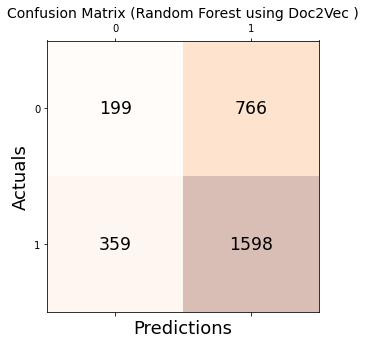

In [209]:
visualizeResults(y_test,  y_pred, "Random Forest using Doc2Vec")

In [213]:
rf = RandomForestClassifier(n_estimators=800, random_state=11).fit(os_data_X_dw, os_data_y_dw)

In [214]:
y_pred = rf.predict(X_test_dw) 
print(classification_report(y_test_dw, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    Disliked       0.66      0.56      0.60       965
       Liked       0.80      0.86      0.83      1957

    accuracy                           0.76      2922
   macro avg       0.73      0.71      0.71      2922
weighted avg       0.75      0.76      0.75      2922



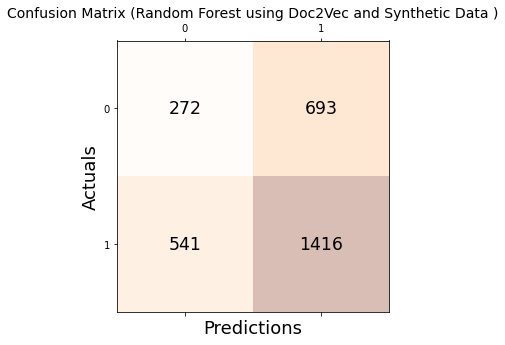

In [215]:
visualizeResults(y_test_dw,  y_pred, "Random Forest using Doc2Vec and Synthetic Data")

##### Using Word2Vec

In [221]:
rf = RandomForestClassifier(n_estimators=800, random_state=11).fit(X_train_wv, y_train_wv)

In [222]:
y_pred = rf.predict(X_test_wv) 
print(classification_report(y_test_wv, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    Disliked       0.77      0.48      0.59       965
       Liked       0.78      0.93      0.85      1957

    accuracy                           0.78      2922
   macro avg       0.78      0.70      0.72      2922
weighted avg       0.78      0.78      0.76      2922



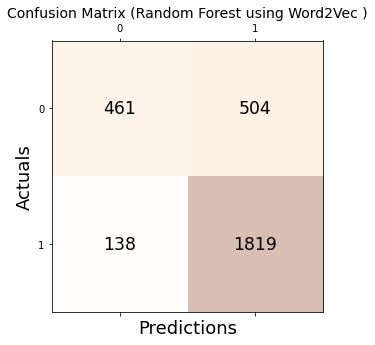

In [223]:
visualizeResults(y_test_wv,  y_pred, "Random Forest using Word2Vec")

In [224]:
rf = RandomForestClassifier(n_estimators=800, random_state=11).fit(os_data_X_wv, os_data_y_wv)

In [225]:
y_pred = rf.predict(X_test_wv) 
print(classification_report(y_test_wv, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    Disliked       0.68      0.60      0.64       965
       Liked       0.81      0.86      0.84      1957

    accuracy                           0.77      2922
   macro avg       0.75      0.73      0.74      2922
weighted avg       0.77      0.77      0.77      2922



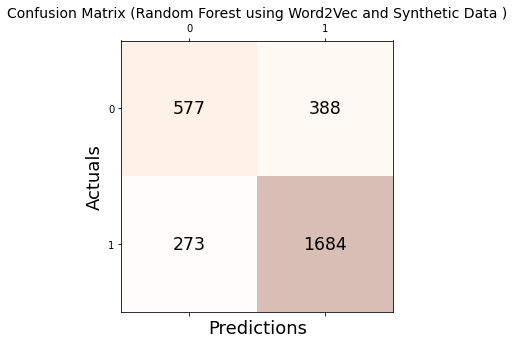

In [226]:
visualizeResults(y_test_wv,  y_pred, "Random Forest using Word2Vec and Synthetic Data")

#### 4. XGBoost
##### 4.1 using Doc2Vec

In [262]:
xgb_model = XGBClassifier(max_depth=6, n_estimators=1000).fit(X_train_dw, y_train_dw)

In [263]:
y_pred = xgb_model.predict(X_test_dw)

print(classification_report(y_test_dw, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    Disliked       0.67      0.55      0.60       965
       Liked       0.79      0.87      0.83      1957

    accuracy                           0.76      2922
   macro avg       0.73      0.71      0.72      2922
weighted avg       0.75      0.76      0.75      2922



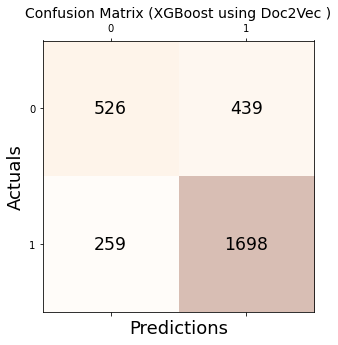

In [264]:
visualizeResults(y_test_dw,  y_pred, "XGBoost using Doc2Vec")

In [265]:
print("F1-Score for XGBoost using Doc2Vec: ",  f1_score(y_test_wv,  y_pred))

F1-Score for XGBoost using Doc2Vec:  0.6971177332681974


In [266]:
xgb_model = XGBClassifier(max_depth=6, n_estimators=1000).fit(os_data_X_dw, os_data_y_dw)

In [267]:
y_pred = xgb_model.predict(X_test_dw)
print(classification_report(y_test_dw, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    Disliked       0.66      0.59      0.62       965
       Liked       0.81      0.85      0.83      1957

    accuracy                           0.76      2922
   macro avg       0.73      0.72      0.72      2922
weighted avg       0.76      0.76      0.76      2922



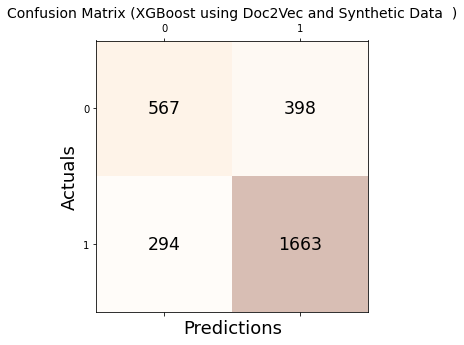

In [268]:
visualizeResults(y_test_dw,  y_pred, "XGBoost using Doc2Vec and Synthetic Data ")

In [269]:
print("F1-Score for XGBoost using Doc2Vec and Synthetic Data : ",  f1_score(y_test_wv,  y_pred))

F1-Score for XGBoost using Doc2Vec and Synthetic Data :  0.6908909905425585


##### Using Word2Vec

In [270]:
xgb_model = XGBClassifier(max_depth=6, n_estimators=1000).fit(X_train_wv, y_train_wv)

In [271]:
y_pred = xgb_model.predict(X_test_wv)
print(classification_report(y_test_wv, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    Disliked       0.70      0.58      0.63       965
       Liked       0.81      0.88      0.84      1957

    accuracy                           0.78      2922
   macro avg       0.75      0.73      0.74      2922
weighted avg       0.77      0.78      0.77      2922



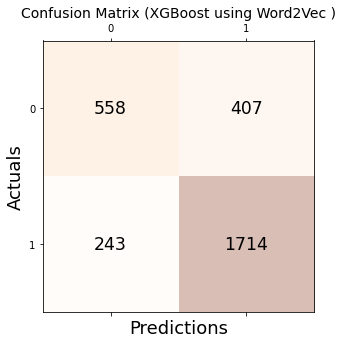

In [272]:
visualizeResults(y_test_wv,  y_pred, "XGBoost using Word2Vec")

In [273]:
print("F1-Score for XGBoost using Word2Vec : ",  f1_score(y_test_wv,  y_pred))

F1-Score for XGBoost using Word2Vec :  0.8406081412457087


In [274]:
xgb_model = XGBClassifier(max_depth=6, n_estimators=1000).fit(os_data_X_wv, os_data_y_wv)

In [275]:
y_pred = xgb_model.predict(X_test_wv)
print(classification_report(y_test_wv, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    Disliked       0.67      0.64      0.66       965
       Liked       0.83      0.85      0.84      1957

    accuracy                           0.78      2922
   macro avg       0.75      0.74      0.75      2922
weighted avg       0.78      0.78      0.78      2922



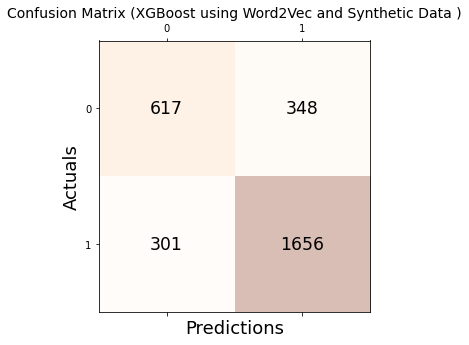

In [276]:
visualizeResults(y_test_wv,  y_pred, "XGBoost using Word2Vec and Synthetic Data")

In [277]:
print("F1-Score for XGBoost using Word2Vec and Synthetic Data : ",  f1_score(y_test_wv,  y_pred))

F1-Score for XGBoost using Word2Vec and Synthetic Data :  0.8361524867457713


### Hyper parameters Tuning for XGBoost

In [291]:
import xgboost as xgb

In [292]:
dtrain = xgb.DMatrix(X_train_wv, label= y_train_dw) 
dvalid = xgb.DMatrix(X_test_wv, label= y_test_wv) 
# dtest = xgb.DMatrix(test_w2v)
# Parameters that we are going to tune 
params = {
    'objective':'binary:logistic',
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1
 }

In [293]:
def custom_eval(preds, dtrain):
    labels = dtrain.get_label().astype(np.int)
    preds = (preds >= 0.3).astype(np.int)
    return [('f1_score', f1_score(labels, preds))]

In [283]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(6,12)
    for min_child_weight in range(5,10)
    ]

max_f1 = 0. # initializing with 0 

best_params = None 

for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(max_depth,min_child_weight))
    
     # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight

     # Cross-validation
    cv_results = xgb.cv(
        params,
        dtrain,
        feval= custom_eval,
        num_boost_round=200,
        maximize=True,
        seed=16,
        nfold=5,
        early_stopping_rounds=10
        )     
    
# Finding best F1 Score    
mean_f1 = cv_results['test-f1_score-mean'].max()
boost_rounds = cv_results['test-f1_score-mean'].idxmax()    
print("\tF1 Score {} for {} rounds".format(mean_f1, boost_rounds))    

if mean_f1 > max_f1:
        max_f1 = mean_f1
        best_params = (max_depth,min_child_weight) 

print("Best params: {}, {}, F1 Score: {}".format(best_params[0], best_params[1], max_f1))

CV with max_depth=6, min_child_weight=5
CV with max_depth=6, min_child_weight=6
CV with max_depth=6, min_child_weight=7
CV with max_depth=6, min_child_weight=8
CV with max_depth=6, min_child_weight=9
CV with max_depth=7, min_child_weight=5
CV with max_depth=7, min_child_weight=6
CV with max_depth=7, min_child_weight=7
CV with max_depth=7, min_child_weight=8
CV with max_depth=7, min_child_weight=9
CV with max_depth=8, min_child_weight=5
CV with max_depth=8, min_child_weight=6
CV with max_depth=8, min_child_weight=7
CV with max_depth=8, min_child_weight=8
CV with max_depth=8, min_child_weight=9
CV with max_depth=9, min_child_weight=5
CV with max_depth=9, min_child_weight=6
CV with max_depth=9, min_child_weight=7
CV with max_depth=9, min_child_weight=8
CV with max_depth=9, min_child_weight=9
CV with max_depth=10, min_child_weight=5
CV with max_depth=10, min_child_weight=6
CV with max_depth=10, min_child_weight=7
CV with max_depth=10, min_child_weight=8
CV with max_depth=10, min_child_weig

In [294]:
params['max_depth'] = 11
params['min_child_weight'] = 9

In [295]:
gridsearch_params = [
    (subsample)
    for subsample in [i/10. for i in range(5,10)]
]

max_f1 = 0. 
best_params = None 

for subsample in gridsearch_params:
    print("CV with subsample={}".format(subsample))
    
    # Update our parameters
    params['subsample'] = subsample
    
    cv_results = xgb.cv(
        params,
        dtrain,
        feval= custom_eval,
        num_boost_round=200,
        maximize=True,
        seed=16,
        nfold=5,
        early_stopping_rounds=10
        )
    
    # Finding best F1 Score
    mean_f1 = cv_results['test-f1_score-mean'].max()
    boost_rounds = cv_results['test-f1_score-mean'].idxmax()
    print("\tF1 Score {} for {} rounds".format(mean_f1, boost_rounds))
    
    if mean_f1 > max_f1:
        max_f1 = mean_f1
        best_params = (subsample) 
print("Best params: {}, F1 Score: {}".format(best_params, max_f1))

CV with subsample=0.5
	F1 Score 0.7014948 for 10 rounds
CV with subsample=0.6
	F1 Score 0.708504 for 9 rounds
CV with subsample=0.7
	F1 Score 0.7056958000000001 for 10 rounds
CV with subsample=0.8
	F1 Score 0.714045 for 10 rounds
CV with subsample=0.9
	F1 Score 0.7169576 for 8 rounds


TypeError: 'float' object is not subscriptable

In [308]:
params = {
    'colsample': 0.9,
    'colsample_bytree': 0.5,
    'eta': 0.1,
    'max_depth': 9,
    'min_child_weight': 7,
    'objective': 'binary:logistic',
    'subsample': 0.9
}

In [312]:
xgb_model = xgb.train(
    params,
    dtrain,
    feval= custom_eval,
    num_boost_round= 1000,
    maximize=True,
    evals=[(dvalid, "Validation")],
    early_stopping_rounds=10
 )

[21:23:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	Validation-rmse:0.48534	Validation-f1_score:0.80221
[1]	Validation-rmse:0.47878	Validation-f1_score:0.80238
[2]	Validation-rmse:0.47653	Validation-f1_score:0.80222
[3]	Validation-rmse:0.47428	Validation-f1_score:0.80205
[4]	Validation-rmse:0.47390	Validation-f1_score:0.80180
[5]	Validation-rmse:0.47446	Validation-f1_score:0.80180
[6]	Validation-rmse:0.47467	Validation-f1_score:0.80180
[7]	Validation-rmse:0.47539	Validation-f1_score:0.80205
[8]	Validation-rmse:0.47560	Validation-f1_score:0.80189
[9]	Validation-rmse:0.47595	Validation-f1_score:0.80173
[10]	Validation-rms

<b> Credits :</b> <br>
To solve this problem statement, help was taking from following online resources.
- https://www.kaggle.com/
- https://medium.com/
- https://medium.com/
- https://www.analyticsvidhya.com/blog/
- https://machinelearningmastery.com/
- And Official Documentation of different libraries and packages used.

   - The End